In [1]:
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import random

from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

from sklearn.metrics import auc, roc_curve



In [2]:
secom_df = np.loadtxt('./secom.data', dtype=str) 
secom_df = pd.DataFrame(preprocessing.scale(secom_df)) #scaling and Data Frame

target = np.loadtxt('./secom_labels.data', dtype=str)

target = pd.DataFrame(target) #Data Frame
times = target[2].str.split(':', expand=True)[0]
time_df = pd.DataFrame(times)
target = target[0].astype(int)
time_df['FPY']=target
labels_df=target


In [3]:
def createList(n):
    lst = []
    for i in range(n+1):
        lst.append('Spalte: ' + str(i) )
    return(lst)
Spaltennamen = createList(secom_df.shape[1]-1)
secom_df.set_axis(Spaltennamen, axis=1,inplace=True)
print(secom_df.head())

   Spalte: 0  Spalte: 1  Spalte: 2  Spalte: 3  Spalte: 4  Spalte: 5  \
0   0.223879   0.847825  -0.434320   0.033405  -0.050354        0.0   
1   1.105015  -0.382054   1.012583   0.152382  -0.059776        0.0   
2  -1.112023   0.797316  -0.479135   0.683141  -0.047691        0.0   
3  -0.349640  -0.198431  -0.051316  -1.101992  -0.051060        0.0   
4   0.241679   0.087330   1.112384  -0.158208  -0.047280        0.0   

   Spalte: 6  Spalte: 7  Spalte: 8  Spalte: 9  ...  Spalte: 580  Spalte: 581  \
0  -0.561266   0.265504   0.509501   1.127696  ...          NaN          NaN   
1   0.197330   0.321317   0.456708   0.022567  ...     0.194011     1.260949   
2  -0.902153   0.254341  -0.260740   0.326974  ...     3.020445    -0.172375   
3   0.500993  -0.013563   0.342999  -0.764920  ...    -0.319886    -0.275485   
4  -0.114865   0.187365   0.544697  -0.149489  ...          NaN          NaN   

   Spalte: 582  Spalte: 583  Spalte: 584  Spalte: 585  Spalte: 586  \
0     0.118661    -0.2

How many observations and features are there?

In [4]:
print('features',secom_df.shape) #590 features, 1567 observations
print('time',times.shape)
print('labels',labels_df.shape)

#sns.histplot(data = labels_df, color= 'grey')
labels_df.value_counts()

features (1567, 590)
time (1567,)
labels (1567,)


-1    1463
 1     104
Name: 0, dtype: int64

look at the data

In [5]:
print(secom_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, Spalte: 0 to Spalte: 589
dtypes: float64(590)
memory usage: 7.1 MB
None


In [6]:
secom_df.head()

,Spalte: 0,Spalte: 1,Spalte: 2,Spalte: 3,Spalte: 4,Spalte: 5,Spalte: 6,Spalte: 7,Spalte: 8,Spalte: 9,...,Spalte: 580,Spalte: 581,Spalte: 582,Spalte: 583,Spalte: 584,Spalte: 585,Spalte: 586,Spalte: 587,Spalte: 588,Spalte: 589
0,0.223879,0.847825,-0.434320,0.033405,-0.050354,0.0,-0.561266,0.265504,0.509501,1.127696,...,NaN,NaN,0.118661,-0.204825,-0.093178,-0.197050,NaN,NaN,NaN,NaN
1,1.105015,-0.382054,1.012583,0.152382,-0.059776,0.0,0.197330,0.321317,0.456708,0.022567,...,0.194011,1.260949,0.530034,0.406549,0.444564,0.384936,-0.959868,0.411722,0.250045,1.156320
2,-1.112023,0.797316,-0.479135,0.683141,-0.047691,0.0,-0.902153,0.254341,-0.260740,0.326974,...,3.020445,-0.172375,-1.262377,0.022257,0.014371,0.029823,2.990196,3.625906,3.320359,-0.179091
3,-0.349640,-0.198431,-0.051316,-1.101992,-0.051060,0.0,0.500993,-0.013563,0.342999,-0.764920,...,-0.319886,-0.275485,-0.322096,-0.292164,-0.362049,-0.283326,-0.101862,-0.178870,-0.308194,-0.275158
4,0.241679,0.087330,1.112384,-0.158208,-0.047280,0.0,-0.114865,0.187365,0.544697,-0.149489,...,NaN,NaN,-5.905014,26.858657,27.062785,26.904758,-0.101862,-0.178870,-0.308194,-0.275158


How do you plan to handle missing values?

In [7]:
print(secom_df.isna().any().any()) 

True


In [8]:
#https://www.elektormagazine.de/articles/datenanalyse-und-knstliche-intelligenz-in-python
na_cols = [col for col in secom_df.columns if secom_df[col].isnull().sum() / len(secom_df) > 0.4]
secom_df = secom_df.drop(na_cols, axis=1)
secom_df.shape

(1567, 558)

In [9]:
#imputer = SimpleImputer(strategy='mean')
imputer = KNNImputer(n_neighbors=12, weights="uniform")
secom_imputed = pd.DataFrame(imputer.fit_transform(secom_df))
secom_imputed.columns = secom_df.columns
secom_df=secom_imputed

In [10]:
print(secom_df.isna().any().any())

False


Check for trends and outliers

In [11]:
secom_df.describe() #there are outliers
#Standartesierung Notwendig

,Spalte: 0,Spalte: 1,Spalte: 2,Spalte: 3,Spalte: 4,Spalte: 5,Spalte: 6,Spalte: 7,Spalte: 8,Spalte: 9,...,Spalte: 576,Spalte: 577,Spalte: 582,Spalte: 583,Spalte: 584,Spalte: 585,Spalte: 586,Spalte: 587,Spalte: 588,Spalte: 589
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1.567000e+03,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,-0.001126,0.000368,0.000305,0.000612,0.017391,0.0,-0.003528,-0.011311,-0.000874,-0.000170,...,-4.676469e-16,-3.101398e-15,0.000330,-0.000054,-0.000045,-0.000055,-0.000493,0.000249,0.000282,0.000325
std,0.998692,0.998288,0.998301,0.996313,1.043059,0.0,0.997243,1.048866,1.000004,0.999710,...,1.000319e+00,1.000319e+00,1.000086,1.000002,1.000002,1.000002,1.000191,1.000049,1.000062,1.000083
min,-3.685048,-4.193732,-4.741357,-3.162447,-0.062401,0.0,-3.044296,-13.598515,-3.680125,-3.478111,...,-2.896758e-01,-9.662759e-01,-6.551457,-0.542536,-0.577145,-0.522892,-3.104882,-1.507703,-1.494452,-1.061880
25%,-0.653928,-0.534514,-0.661034,-0.707714,-0.056433,0.0,-0.518846,-0.080539,-0.700685,-0.659039,...,-2.456434e-01,-4.118818e-01,-0.645317,-0.216470,-0.200726,-0.212846,-0.652281,-0.667245,-0.691984,-0.589179
50%,-0.043247,0.044908,0.017604,-0.246910,-0.051119,0.0,0.060831,0.064576,-0.018432,-0.030373,...,-2.328715e-01,-2.262959e-01,0.030510,-0.088373,-0.066291,-0.086703,-0.077579,-0.190228,-0.238415,-0.294550
75%,0.571850,0.533761,0.593424,0.439097,-0.047356,0.0,0.548032,0.220853,0.730827,0.611528,...,-2.164669e-01,3.513558e-02,0.662261,0.068838,0.068145,0.063498,0.497123,0.434437,0.389604,0.160658
max,4.645455,4.361550,3.888312,5.251202,19.708750,0.0,4.512970,0.756660,2.619881,5.012191,...,5.016547e+00,6.435055e+00,2.851353,26.858657,27.062785,26.904758,6.584107,7.203531,8.135170,6.793326


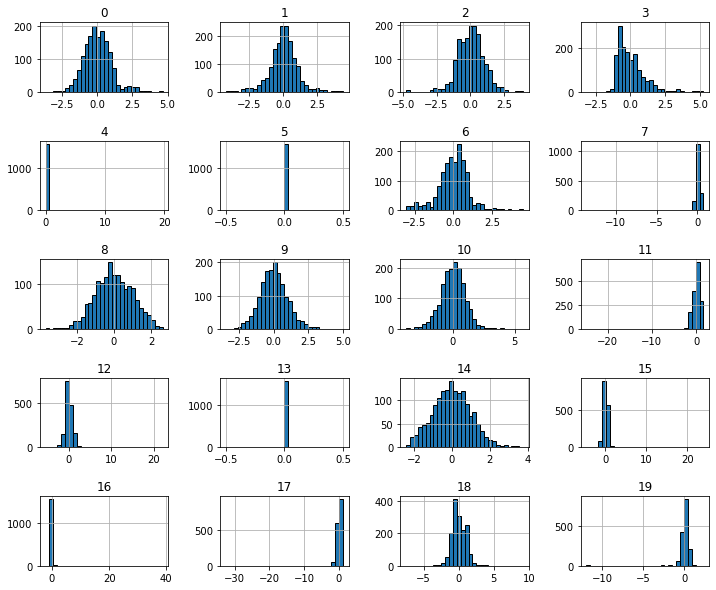

In [12]:
pd.DataFrame(np.array(secom_df)[:,0:20]).hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
#es gibt Konstanten #sehe auch in der Beschreibung der Daten

In [13]:
#Entferne Konstanten
secom_df=secom_df.loc[:, (secom_df != secom_df.iloc[0]).any()]
secom_df.shape

(1567, 442)

Are there redundant features?

<AxesSubplot:>

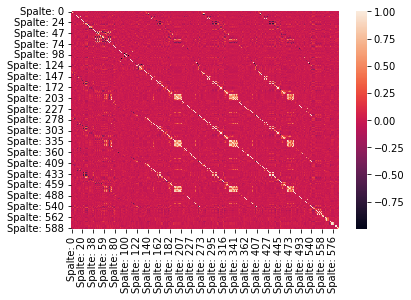

In [14]:
sns.heatmap(secom_df.corr())
#es existiert eine Korrelation, also es gibt in den Daten redundante Werte

In [15]:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python#mcetoc_1g0c4fnd4a
df= secom_df
cor_matrix = df.corr(method="spearman").abs()
#print(cor_matrix)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
upper_tri.set_axis(list(range(0,secom_df.shape[1])), axis=1,inplace=True)
#print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
secom_df = df.drop(df.columns[to_drop], axis=1) # geht nur ein mal
#print(secom_df.head())
secom_df.shape #Redundante Werte sind entfernt

(1567, 371)

In [16]:
#print(Spaltennamen)
print(secom_df)

      Spalte: 0  Spalte: 1  Spalte: 2  Spalte: 3  Spalte: 4  Spalte: 6  \
0      0.223879   0.847825  -0.434320   0.033405  -0.050354  -0.561266   
1      1.105015  -0.382054   1.012583   0.152382  -0.059776   0.197330   
2     -1.112023   0.797316  -0.479135   0.683141  -0.047691  -0.902153   
3     -0.349640  -0.198431  -0.051316  -1.101992  -0.051060   0.500993   
4      0.241679   0.087330   1.112384  -0.158208  -0.047280  -0.114865   
...         ...        ...        ...        ...        ...        ...   
1562  -1.563121  -0.391758  -0.705473   3.825170  -0.048151  -3.025756   
1563   0.514375   0.332161  -0.067131  -0.615372  -0.058943  -0.424045   
1564  -0.484290  -1.443984   0.194982  -0.647447  -0.059879  -0.272759   
1565  -1.624128   0.449849  -0.796987  -0.481595  -0.046584  -0.371296   
1566  -0.944764  -0.560950  -0.172959   3.437447  -0.046137  -2.567968   

      Spalte: 7  Spalte: 8  Spalte: 9  Spalte: 10  ...  Spalte: 574  \
0      0.265504   0.509501   1.127696   

feature importances

In [17]:
# ANOVA feature selection for numeric input and categorical output
k=40
# define feature selection ANOVA entspricht Ftest
fs = SelectKBest(score_func=f_classif, k=k, feature_names_in_ = Spaltennamen)
# apply feature selection 
secom_df = pd.DataFrame(fs.fit_transform(secom_df, labels_df))
print(secom_df) #Spaltennamen sollten alte sein

TypeError: __init__() got an unexpected keyword argument 'feature_names_in_'

In [ ]:
secom_df.keys() #->key falsch gesetzt

Aufgabe 2

Are there specific times with a higher rate of errors?

In [ ]:
plt.hist(time_df[time_df['FPY'] != '1'][0]);

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(secom_df, labels_df, test_size = 0.2, random_state = 42)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Develop a prediction model for First Pass Yield (FPY)

In [ ]:
lr = LogisticRegression(max_iter=10000,random_state=0, penalty='l1', solver='liblinear')
lr1 = lr.fit(X_train, y_train)
y_pred_lr= lr1.predict(X_test)
y_pred_lr_prob = lr1.predict_proba(X_test)


rf = RandomForestClassifier(n_estimators=100)
rf1 = rf.fit(X_train,y_train)
y_pred_rf = rf1.predict(X_test)
y_pred_rf_prob = rf1.predict_proba(X_test)

gbm = GradientBoostingClassifier()
gbm1 = gbm.fit(X_train,y_train)
y_pred_gbm= gbm1.predict(X_test)
y_pred_gbm_prob = gbm1.predict_proba(X_test)

b = BaggingClassifier()
b1 = b.fit(X_train,y_train)
y_pred_b= b1.predict(X_test)
y_pred_b_prob = b1.predict_proba(X_test)

In [ ]:
print("accuracy score train")
print("LassoClassifier: {0}".format(lr1.score(X_train,y_train)))
print("RandomForestClassifier: {0}".format(rf1.score(X_train,y_train)))
print("GradientBoostingClassifier: {0}".format(gbm1.score(X_train,y_train)))
print("BaggingClassifier: {0}".format(b1.score(X_train,y_train)))

In [ ]:
score_lr = cross_validate(lr, X_train,y_train, cv=5, return_train_score=True)
score_rf = cross_validate(rf, X_train,y_train, cv=5, return_train_score=True)
score_gbm = cross_validate(gbm, X_train,y_train, cv=5, return_train_score=True)
score_b = cross_validate(b, X_train,y_train, cv=5, return_train_score=True)

print("accuracy score train cross-validation")
print("LassoClassifier: {0}".format(score_lr['train_score'].mean()))
print("RandomForestClassifier: {0}".format(score_rf['train_score'].mean()))
print("GradientBoostingClassifier: {0}".format(score_gbm['train_score'].mean()))
print("BaggingClassifier: {0}".format(score_b['train_score'].mean()))

In [ ]:
def RandomForestHyper(x_train,y_train):

    rf = RandomForestClassifier(random_state=0)
    
    distributions = {'n_estimators':[200,300,400,500,1000,1500,2000],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_leaf':[1,2,4],
                     'min_samples_split':[2,4,6,8,10]}
    opt = GridSearchCV(estimator = rf, param_grid = distributions, 
                              cv = 5, n_jobs = -1, verbose = 2)
    opt.fit(X_train,y_train)
    print(opt.best_estimator_)
    print(opt.best_score_)
    return opt

def GradientBoostingHyper(x_train,y_train):
  
    gb = GradientBoostingClassifier(random_state=0)
    
    distributions = {'n_estimators':[200,300,400,500,1000,1500,2000],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_leaf':[1,2,4],
                     'min_samples_split':[2,4,6,8,10]}
    opt = GridSearchCV(estimator = gb, param_grid = distributions, 
                              cv = 5, n_jobs = -1, verbose = 2)
    opt.fit(X_train,y_train)
    print(opt.best_estimator_)
    print(opt.best_score_)
    return opt


In [ ]:
res_rf = RandomForestHyper(X_train,y_train.ravel())
res_boost2 = GradientBoostingHyper(X_train,y_train.ravel())


Which of the process features are important for the prediction of First Pass
Yield (FPY)?

In [ ]:
# GBM
gbm_importance = gbm.feature_importances_
gbm_ranked_indices = np.argsort(gbm_importance)[::-1]

#Random Forest
rf_importance = rf.feature_importances_
rf_ranked_indices = np.argsort(rf_importance)[::-1]

#Boosting
b_importance = np.mean([tree.feature_importances_ for tree in b.estimators_], axis=0)
b_ranked_indices = np.argsort(b_importance)[::-1]

# printing results in a table
importance_results = pd.DataFrame(index=range(1,16), 
                                  columns=pd.MultiIndex.from_product([['GBM','RF','B'],['Feature #','Importance']]))
importance_results.index.name = 'Rank'
importance_results.loc[:,'GBM'] =  list(zip(gbm_ranked_indices[:15], 
                                            gbm_importance[gbm_ranked_indices[:15]]))
importance_results.loc[:,'RF'] =  list(zip(rf_ranked_indices[:15], 
                                           rf_importance[rf_ranked_indices[:15]]))
importance_results.loc[:,'B'] =  list(zip(b_ranked_indices[:15], 
                                           b_importance[b_ranked_indices[:15]]))
print(importance_results)

#Auswertung fehlt

Assess the accuracy of the prediction

In [ ]:
print("accuracy score train")
print("LassoClassifier: {0}".format(lr1.score(X_train,y_train)))
print("RandomForestClassifier: {0}".format(rf1.score(X_train,y_train)))
print("GradientBoostingClassifier: {0}".format(gbm1.score(X_train,y_train)))
print("BaggingClassifier: {0}".format(b1.score(X_train,y_train)))

In [ ]:
#FPR and TRP for ROC-curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_lr_prob[: , 1], pos_label= 1)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_rf_prob[: , 1], pos_label= 1)
fpr_gbm, tpr_gbm, thresholds = roc_curve(y_test, y_pred_gbm_prob[: , 1], pos_label= 1)
fpr_b, tpr_b, thresholds = roc_curve(y_test, y_pred_b_prob[: , 1], pos_label= 1)


#ROC curves for false positive rate and true postive rate
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Connect diagonals
ax.plot([0, 1], [0, 1], ls="--")

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for the false positive rate and the true postive rate')

ax.plot(fpr_lr, tpr_lr, label = "lr")
ax.plot(fpr_rf, tpr_rf, label = "rf")
ax.plot(fpr_gbm, tpr_gbm, label = "gbm")
ax.plot(fpr_b, tpr_b, label = "b")

# Set legend and show plot
ax.legend(loc="lower right")
plt.show()


In [ ]:
print("accuracy score test")
print("LassoClassifier: {0}".format(accuracy_score(y_test,y_pred_lr)))
print("RandomForestClassifier: {0}".format(accuracy_score(y_test,y_pred_rf)))
print("GradientBoostingClassifier: {0}".format(accuracy_score(y_test,y_pred_gbm)))
print("BaggingClassifier: {0}".format(accuracy_score(y_test,y_pred_b)))